In [38]:
# importing the necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Loading images from paths
image_files = ['/content/p1.jpeg', '/content/p2.jpeg', '/content/p3.jpeg']
images = [cv2.imread(img) for img in image_files]


In [40]:
# SIFT detector initialization
sift = cv2.SIFT_create(nfeatures=3000)  # Keeping up to 4000 keypoints per image

In [41]:
# Extracting keypoints and descriptors
keypoints_data, descriptors_data = [], []

for img in images:
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(grayscale, None)
    keypoints_data.append(keypoints)
    descriptors_data.append(descriptors)

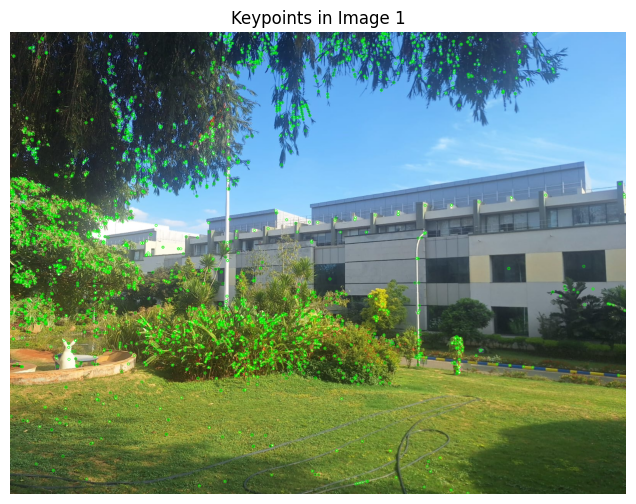

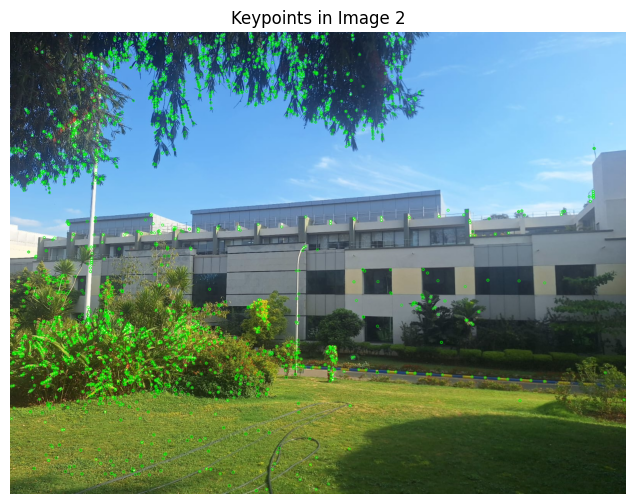

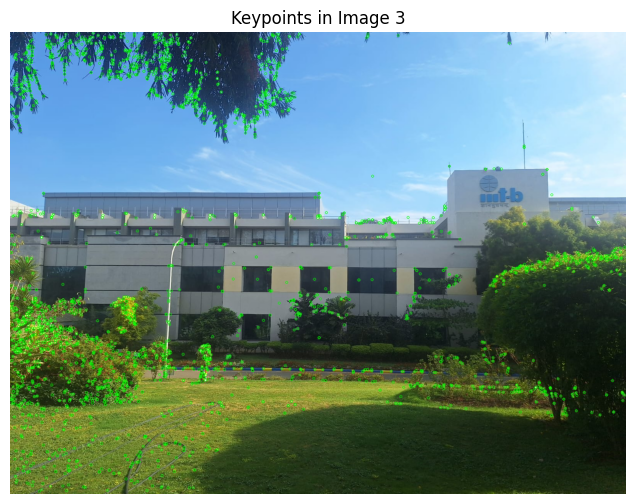

In [42]:
# Visualizing keypoints on each image
for index, img in enumerate(images):
    keypoint_visual = cv2.drawKeypoints(img, keypoints_data[index], None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(keypoint_visual, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Keypoints in Image {index + 1}")
    plt.show()

In [44]:
# FLANN-based matcher for better feature matching
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
matcher = cv2.FlannBasedMatcher(index_params, search_params)

In [45]:
# Function to filter matches using Lowe's ratio test
def filter_matches(matches, ratio=0.75):
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    return good_matches

In [46]:
# Matching features between the first two images
matches_1_2 = matcher.knnMatch(descriptors_data[0], descriptors_data[1], k=2)
good_matches_1_2 = filter_matches(matches_1_2)

In [47]:
# Extracting matching keypoints
points_1 = np.float32([keypoints_data[0][m.queryIdx].pt for m in good_matches_1_2]).reshape(-1, 1, 2)
points_2 = np.float32([keypoints_data[1][m.trainIdx].pt for m in good_matches_1_2]).reshape(-1, 1, 2)

In [48]:
# Computing homography
H1, _ = cv2.findHomography(points_2, points_1, cv2.RANSAC, 5.0)

In [49]:
# Warping second image to align with first
h1, w1 = images[0].shape[:2]
stitched_1_2 = cv2.warpPerspective(images[1], H1, (w1 + images[1].shape[1], h1))
stitched_1_2[0:h1, 0:w1] = images[0]

In [50]:
# Matching features between the second and third images
matches_2_3 = matcher.knnMatch(descriptors_data[1], descriptors_data[2], k=2)
good_matches_2_3 = filter_matches(matches_2_3)

In [51]:
# Extracting keypoints for third image
points_2 = np.float32([keypoints_data[1][m.queryIdx].pt for m in good_matches_2_3]).reshape(-1, 1, 2)
points_3 = np.float32([keypoints_data[2][m.trainIdx].pt for m in good_matches_2_3]).reshape(-1, 1, 2)

In [52]:
# Computing homography for third image
H2, _ = cv2.findHomography(points_3, points_2, cv2.RANSAC, 5.0)

In [53]:
# Warping third image onto the stitched result
h2, w2 = stitched_1_2.shape[:2]
stitched_1_2_3 = cv2.warpPerspective(images[2], H2, (w2 + images[2].shape[1], h2))
stitched_1_2_3[0:h2, 0:w2] = stitched_1_2

In [54]:
# Converting to grayscale and find non-black region
gray_stitched = cv2.cvtColor(stitched_1_2_3, cv2.COLOR_BGR2GRAY)
_, binary_mask = cv2.threshold(gray_stitched, 1, 255, cv2.THRESH_BINARY)

In [55]:
# Identifying the largest bounding rectangle
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])
cropped_final = stitched_1_2_3[y:y+h, x:x+w]

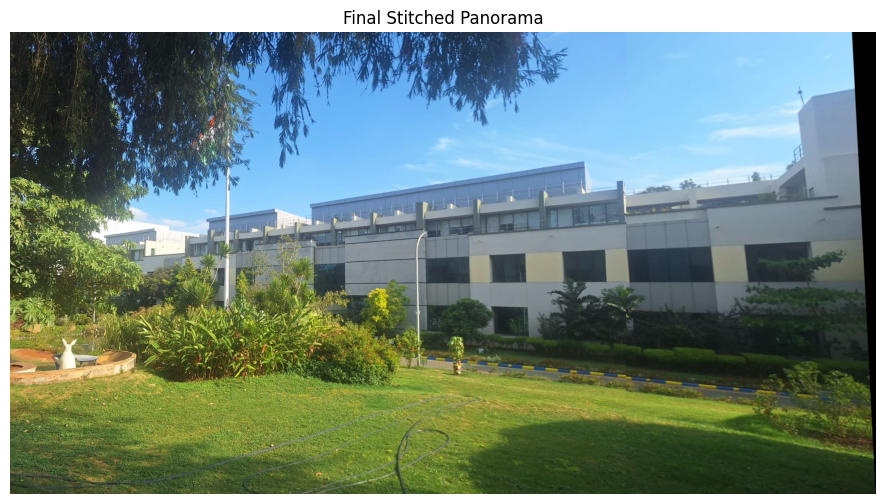

True

In [56]:
# Displaying final stitched output
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(cropped_final, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Final Stitched Panorama")
plt.show()

cv2.imwrite("stitched_panorama_output.jpg", cropped_final)